# Data Visualisation

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
np.random.seed(42)
random.seed(42)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = 'passwords.txt'
df = pd.read_csv(file_path, header=None, names=['password'])

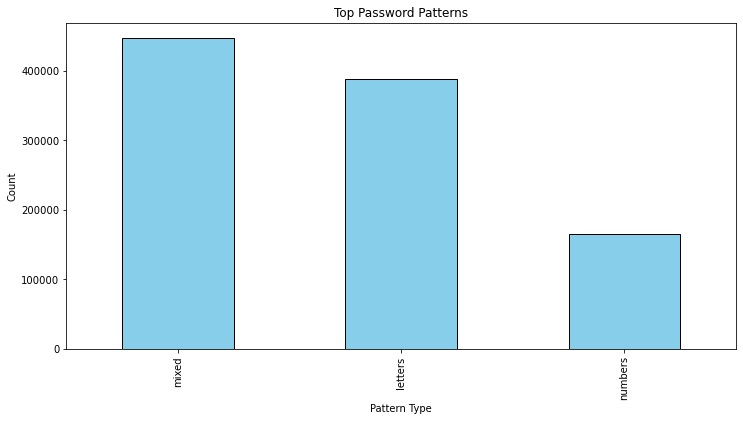

In [3]:
# Replace NaN values with empty strings and then apply the lambda function
patterns = df['password'].fillna('').apply(lambda x: 'numbers' if x.isdigit() else ('letters' if x.isalpha() else 'mixed'))
pattern_counts = patterns.value_counts()

plt.figure(figsize=(12, 6))
pattern_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Pattern Type')
plt.ylabel('Count')
plt.title('Top Password Patterns')
plt.show()


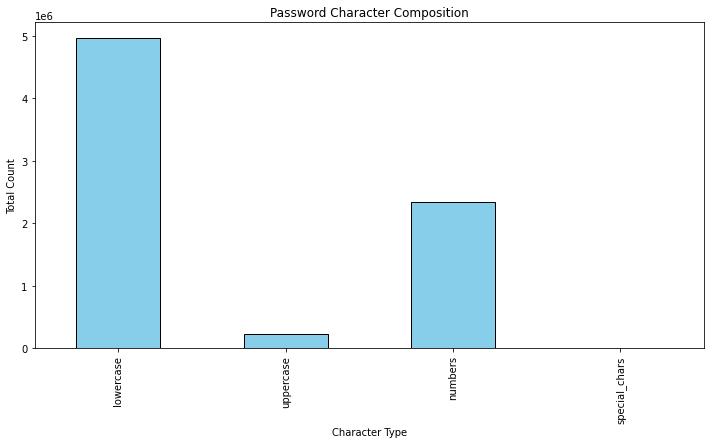

In [4]:
df['password'] = df['password'].fillna('')

composition_df = pd.DataFrame({
    'lowercase': df['password'].str.count(r'[a-z]'),
    'uppercase': df['password'].str.count(r'[A-Z]'),
    'numbers': df['password'].str.count(r'[0-9]'),
    'special_chars': df['password'].str.count(r'[^a-zA-Z0-9]')
})

plt.figure(figsize=(12, 6))
composition_df.sum().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Character Type')
plt.ylabel('Total Count')
plt.title('Password Character Composition')
plt.show()


# Hash Function

In [5]:
import mmh3

class HierarchicalHashFunction:
    def __init__(self, num_hashes, size, seed=42):  # Default seed
        self.num_hashes = num_hashes
        self.size = size
        self.seed = seed  # Set a fixed seed for reproducibility

    def generate_hashes(self, item):
        hash_values = []
        base_hash = mmh3.hash(item, self.seed)  # Use seed here

        for i in range(self.num_hashes):
            intermediate_hash = (base_hash + i * 0x5bd1e995) % self.size
            final_hash = mmh3.hash(str(intermediate_hash), self.seed + i) % self.size
            hash_values.append(final_hash % self.size)

        return hash_values


# Counting Bloom Filter Module

In [6]:
class CountingBloomFilter:
    def __init__(self, size, num_hashes, hash_function):
        self.size = size
        self.num_hashes = num_hashes
        self.counters = [0] * size
        self.hash_function = hash_function

        # Debug: Verify size initialization
        if len(self.counters) != size:
            raise ValueError("Counting Bloom Filter counters size mismatch!")

    def add(self, item):
        for hash_value in self.hash_function.generate_hashes(item):
            if hash_value >= self.size or hash_value < 0:
                raise ValueError(f"Hash value {hash_value} is out of bounds!")
            self.counters[hash_value] += 1


    def remove(self, item):
        for hash_value in self.hash_function.generate_hashes(item):
            if self.counters[hash_value] > 0:
                self.counters[hash_value] -= 1

    def check(self, item):
        return all(self.counters[hash_value] > 0 for hash_value in self.hash_function.generate_hashes(item))

# Cuckoo Hash Table Module

In [7]:
import hashlib

class CuckooHashTable:
    def __init__(self, size, hash_function):
        self.size = size
        self.table = [None] * size
        self.hash_function = hash_function

    def _hashes(self, item):
        return [mmh3.hash(item + str(i), i) % self.size for i in range(2)]

    def insert(self, item, max_relocations=50):
        for _ in range(max_relocations):
            for hash_value in self._hashes(item):
                if self.table[hash_value] is None:
                    self.table[hash_value] = item
                    return True
                else:
                    # Perform displacement (swap)
                    item, self.table[hash_value] = self.table[hash_value], item

        # If insertion fails
        print("Cuckoo Hashing insertion failed after max relocations.")
        return False

    def lookup(self, item):
        return any(self.table[hash_value] == item for hash_value in self._hashes(item))

    def remove(self, item):
        for hash_value in self._hashes(item):
            if self.table[hash_value] == item:
                self.table[hash_value] = None
                return True
        return False


# Data Handling Module

In [8]:
import pandas as pd

def load_dataset(file_path, chunk_size=None):
    if chunk_size:
        return pd.read_csv(file_path, header=None, names=['password'], chunksize=chunk_size)
    else:
        df = pd.read_csv(file_path, header=None, names=['password'])
        df['password'] = df['password'].astype(str)
        df = df[df['password'].apply(lambda x: isinstance(x, str) and x != 'nan')]
        return df


# Performance Evaluation Module

In [9]:
import time

def evaluate_structure(structure, passwords):
    start_time = time.time()
    for password in passwords:
        if hasattr(structure, 'add'):
            structure.add(password)  # Counting Bloom Filter
        elif hasattr(structure, 'insert'):
            structure.insert(password)  # Cuckoo Hash Table
    insertion_time = time.time() - start_time

    lookup_start_time = time.time()
    for password in passwords:
        if hasattr(structure, 'check'):
            structure.check(password)  # Counting Bloom Filter
        elif hasattr(structure, 'lookup'):
            structure.lookup(password)  # Cuckoo Hash Table
    lookup_time = time.time() - lookup_start_time

    return insertion_time, lookup_time




# Main Script

In [10]:
# Load dataset
file_path = 'passwords.txt'
df = load_dataset(file_path)

# Initialize structures
size = 10**6
num_hashes = 7
hash_function = HierarchicalHashFunction(num_hashes, size)

cbf = CountingBloomFilter(size, num_hashes, hash_function)
cht = CuckooHashTable(size, hash_function)

# Evaluate on sample passwords
sample_passwords = df['password'].head(10000)

# Evaluate Counting Bloom Filter
cbf_insertion, cbf_lookup = evaluate_structure(cbf, sample_passwords)
print(f"CBF Insertion Time: {cbf_insertion}, Lookup Time: {cbf_lookup}")

# Evaluate Cuckoo Hash Table
cht_insertion, cht_lookup = evaluate_structure(cht, sample_passwords)
print(f"CHT Insertion Time: {cht_insertion}, Lookup Time: {cht_lookup}")


CBF Insertion Time: 0.10769796371459961, Lookup Time: 0.10429167747497559
CHT Insertion Time: 0.0308380126953125, Lookup Time: 0.032476186752319336


# Scalability Testing

In [11]:
def scalability_test(structure_class, dataset, size_list, num_hashes):
    results = []
    for size in size_list:
        try:
            # Pass appropriate arguments to each structure
            if structure_class == CountingBloomFilter:
                structure = structure_class(size, num_hashes, HierarchicalHashFunction(num_hashes, size))
            elif structure_class == CuckooHashTable:
                structure = structure_class(size, HierarchicalHashFunction(2, size))  # CHT uses 2 hash functions
            
            sample_passwords = dataset.head(10000)['password']

            # Measure insertion time
            start_time = time.time()
            for password in sample_passwords:
                if hasattr(structure, 'add'):
                    structure.add(password)
                elif hasattr(structure, 'insert'):
                    structure.insert(password)
            insertion_time = time.time() - start_time

            # Measure lookup time
            lookup_start_time = time.time()
            for password in sample_passwords:
                if hasattr(structure, 'check'):
                    structure.check(password)
                elif hasattr(structure, 'lookup'):
                    structure.lookup(password)
            lookup_time = time.time() - lookup_start_time

            results.append({
                'size': size,
                'num_hashes': num_hashes,
                'insertion_time': insertion_time,
                'lookup_time': lookup_time
            })
        except Exception as e:
            print(f"Error during test for size={size}, num_hashes={num_hashes}: {e}")
    return pd.DataFrame(results)

# Error Handling in Cuckoo Hash Table

In [12]:
class CuckooHashTable:
    def __init__(self, size, hash_function):
        self.size = size
        self.table = [None] * size
        self.hash_function = hash_function

    def _hashes(self, item):
        return [mmh3.hash(item + str(i), i) % self.size for i in range(2)]

    def insert(self, item, max_relocations=50):
        for _ in range(max_relocations):
            for hash_value in self._hashes(item):
                if self.table[hash_value] is None:
                    self.table[hash_value] = item
                    return True
                else:
                    item, self.table[hash_value] = self.table[hash_value], item

        print("Cuckoo Hashing insertion failed. Rehashing required.")
        self._rehash()
        return self.insert(item, max_relocations)

    def _rehash(self):
        old_table = self.table
        self.size *= 2
        self.table = [None] * self.size
        for item in old_table:
            if item is not None:
                self.insert(item)

    def lookup(self, item):
        return any(self.table[hash_value] == item for hash_value in self._hashes(item))

    def remove(self, item):
        for hash_value in self._hashes(item):
            if self.table[hash_value] == item:
                self.table[hash_value] = None
                return True
        return False


# Comprehensive Performance Report

In [13]:
def generate_performance_report(results_df):
    print("\nPerformance Report:\n")
    print(results_df)

    # Visualize insertion and lookup times
    plt.figure(figsize=(14, 6))
    for size in results_df['size'].unique():
        subset = results_df[results_df['size'] == size]
        plt.plot(subset['num_hashes'], subset['insertion_time'], marker='o', label=f'Size = {size}')
    plt.title('Insertion Time vs. Number of Hash Functions')
    plt.xlabel('Number of Hash Functions')
    plt.ylabel('Insertion Time (s)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 6))
    for size in results_df['size'].unique():
        subset = results_df[results_df['size'] == size]
        plt.plot(subset['num_hashes'], subset['lookup_time'], marker='o', label=f'Size = {size}')
    plt.title('Lookup Time vs. Number of Hash Functions')
    plt.xlabel('Number of Hash Functions')
    plt.ylabel('Lookup Time (s)')
    plt.legend()
    plt.grid(True)
    plt.show()



Performance Report:

       size  num_hashes  insertion_time  lookup_time
0    100000           3        0.047285     0.048120
1    500000           3        0.050280     0.050198
2   1000000           3        0.051194     0.051874
3    100000           5        0.072669     0.069545
4    500000           5        0.072246     0.072070
5   1000000           5        0.073711     0.073236
6    100000           7        0.099636     0.090949
7    500000           7        0.097838     0.098038
8   1000000           7        0.098756     0.101349
9    100000          10        0.145571     0.123871
10   500000          10        0.135279     0.134299
11  1000000          10        0.138051     0.132807


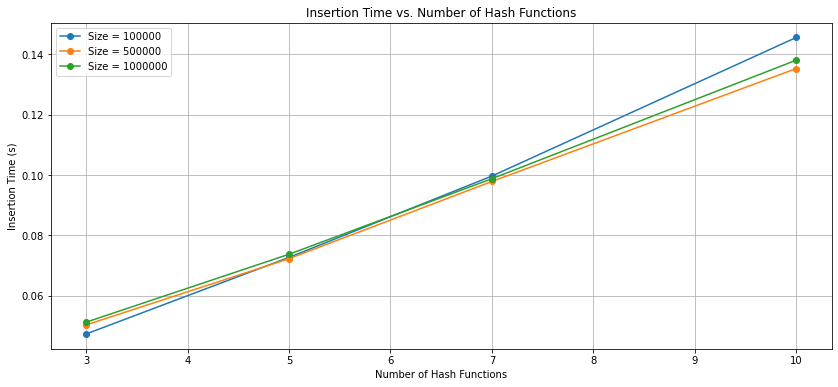

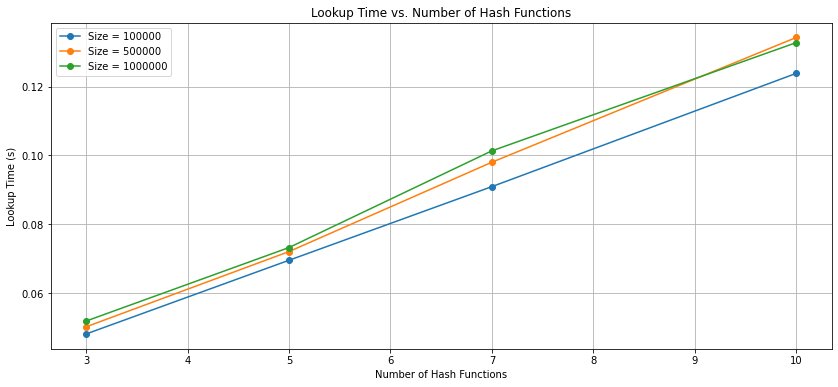


Performance Report:

       size  num_hashes  insertion_time  lookup_time
0    100000           3        0.029738     0.032542
1    500000           3        0.034151     0.033452
2   1000000           3        0.030364     0.034541
3    100000           5        0.029803     0.031146
4    500000           5        0.030090     0.031573
5   1000000           5        0.029563     0.031352
6    100000           7        0.029511     0.031193
7    500000           7        0.029888     0.032053
8   1000000           7        0.029827     0.032564
9    100000          10        0.030553     0.031696
10   500000          10        0.030696     0.034643
11  1000000          10        0.030850     0.032253


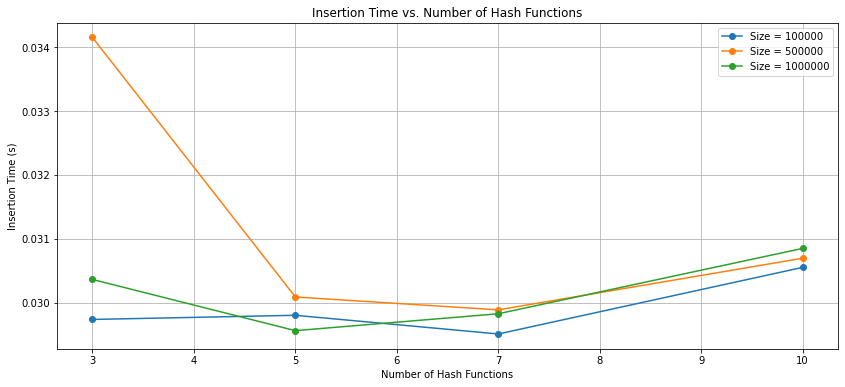

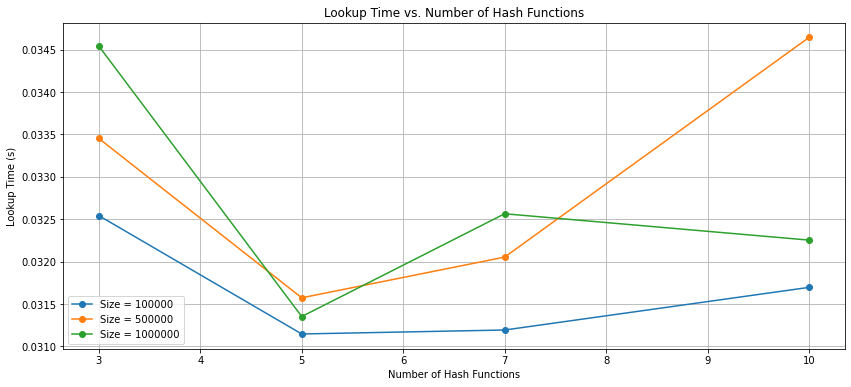

In [14]:
import time

# Load dataset
file_path = 'passwords.txt'
df = load_dataset(file_path)

# Define configurations
sizes = [10**5, 5 * 10**5, 10**6]  # Different sizes for testing scalability
num_hashes_list = [3, 5, 7, 10]  # Test different numbers of hash functions

# Test Counting Bloom Filter scalability
cbf_results = []
for num_hashes in num_hashes_list:
    try:
        cbf_results_df = scalability_test(CountingBloomFilter, df, sizes, num_hashes)
        cbf_results.append(cbf_results_df)
    except Exception as e:
        print(f"Error during scalability test for Counting Bloom Filter with num_hashes={num_hashes}: {e}")

# Combine and generate report for Counting Bloom Filter
if cbf_results:
    cbf_results = pd.concat(cbf_results, ignore_index=True)
    generate_performance_report(cbf_results)

# Test Cuckoo Hash Table scalability
cht_results = []
for num_hashes in num_hashes_list:
    try:
        cht_results_df = scalability_test(CuckooHashTable, df, sizes, num_hashes)
        cht_results.append(cht_results_df)
    except Exception as e:
        print(f"Error during scalability test for Cuckoo Hash Table with num_hashes={num_hashes}: {e}")

# Combine and generate report for Cuckoo Hash Table
if cht_results:
    cht_results = pd.concat(cht_results, ignore_index=True)
    generate_performance_report(cht_results)

